# Задача. Оценка релевантности организаций запросам на Яндекс.Картах с помощью LLM-агента

<img src="https://sun9-65.userapi.com/impg/N4y2cxlL7PauAs82tBNFOUAiNctFICWDy4Mbiw/Jiz1fb7NLWU.jpg?size=1080x1080&quality=95&sign=df2786058624d9ccac3ede4d5d056e2f&type=album" width="200" height="200" />


## Описание задачи

Необходимо создать LLM-агента, который будет оценивать релевантность организаций на Яндекс.Картах широким запросам (например, "ресторан с верандой" или "романтичный джаз-бар"). Такие запросы называются *рубричными*: пользователь здесь ищет не конкретную организацию, а идёт в Яндекс.Карты для поиска и выбора мест.

LLM-агент должен самостоятельно находить необходимые данные для принятия правильного решения.

Данные представлены компанией Яндекс и являются результатами асессорской разметки релевантности.


## Установка библиотек и импорты

In [1]:
!pip install -U langchain langchain_community langchain-openai openai langgraph langchain-core pydantic selenium --quiet
!pip install llama-index llama-index-embeddings-huggingface llama-index-embeddings-langchain faiss-cpu --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.

In [2]:
import builtins
import json
import os
import random
import re
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from pydantic import BaseModel
from IPython.display import Image, display
from sklearn.metrics import accuracy_score

# типы
from typing import Optional, TypedDict, Union, Literal, List

# LangChain / LangGraph
from langchain import PromptTemplate, FewShotPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# Llama Index
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.schema import TextNode
from llama_index.core.node_parser import SimpleNodeParser, SentenceSplitter

warnings.filterwarnings("ignore", category=ImportWarning)

## Загрузка данных

In [ ]:
# Используем сэмпл из 500 строк для демонстрации.
# Полный датасет (~30k строк) не включён в репозиторий.
# В реальном пайплайне создаётся векторная база по полным данным.

In [ ]:
import pandas as pd

# ссылки на raw-файлы в GitHub
train_url = "https://raw.githubusercontent.com/Diank/relevance_llm_agent/main/data/train_data_sample500.jsonl"
eval_url = "https://raw.githubusercontent.com/Diank/relevance_llm_agent/main/data/eval_data.jsonl"

# загрузка
train_data = pd.read_json(train_url, lines=True)
eval_data = pd.read_json(eval_url, lines=True)

print(f"Train size: {len(train_data)} | Eval size: {len(eval_data)}")

In [45]:
train_data.head(2)

,query,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,assessor_label
0,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,1377658436,None,Организация занимается обслуживанием налогопла...,0
1,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,1085001465,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...,1


## EDA

In [49]:
train_data.info()

# в prices_summarized и reviews_summarized есть пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   query                           500 non-null    object
 1   address                         500 non-null    object
 2   name                            500 non-null    object
 3   normalized_main_rubric_name_ru  500 non-null    object
 4   permalink                       500 non-null    int64 
 5   prices_summarized               311 non-null    object
 6   reviews_summarized              490 non-null    object
 7   assessor_label                  500 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [50]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   query                           500 non-null    object
 1   address                         500 non-null    object
 2   name                            500 non-null    object
 3   normalized_main_rubric_name_ru  500 non-null    object
 4   permalink                       500 non-null    int64 
 5   prices_summarized               293 non-null    object
 6   reviews_summarized              485 non-null    object
 7   assessor_label                  500 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [51]:
# баланс классов
# 1 - RELEVANT_PLUS
# 0 - IRRELEVANT

train_data['assessor_label'].value_counts()

,count
assessor_label,
1,261
0,239


In [52]:
train_data['normalized_main_rubric_name_ru'].value_counts()

,count
normalized_main_rubric_name_ru,
Ресторан,51
Кафе,26
"Медцентр , клиника",20
"Автосервис , автотехцентр",16
Гостиница,13
...,...
Кинотеатр,1
Отдых на ферме,1
Отделение полиции,1


## Pipeline подготовки данных

In [37]:
# В исходных данных метки: 1 (RELEVANT_PLUS) и 0 (IRRELEVANT)

# Для удобства работы с агентом заменяем:
#   1 -> RELEVANT_PLUS
#   0 -> IRRELEVANT

In [53]:
def data_preparation_pipeline(data):
    data = data.copy()

    data["prices_summarized"] = data["prices_summarized"].fillna("Информация отсутствует")
    data["reviews_summarized"] = data["reviews_summarized"].fillna("Информация отсутствует")

    # Преобразуем метки в строковый тип
    data["assessor_label"] = data["assessor_label"].replace({
        1: 'RELEVANT_PLUS',
        0: 'IRRELEVANT'
    }).astype(str)

    return data


In [54]:
train_data = data_preparation_pipeline(train_data)
eval_data = data_preparation_pipeline(eval_data)

In [55]:
train_data.head(2)

,query,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,assessor_label
0,УСЛУГИ ВАКУМА,"Свердловская область, Берёзовский, Берёзовский...",ВаКум; VaKum,"Автосервис , автотехцентр",146928520292,"Предоставляет услуги по уходу за автомобилем, ...",Организация занимается автообслуживанием и мой...,IRRELEVANT
1,Сетевые лаборатории,"Москва, улица Шаболовка, 50",CMD — Центр Молекулярной Диагностики; CMD; Cmd...,Медицинская лаборатория,1869408430,CMD — Центр Молекулярной Диагностики предостав...,Организация занимается проведением анализов и ...,RELEVANT_PLUS


## Инициализация LLM-модели для агента

In [56]:
GOOGLE_API_KEY = "my_key"
GOOGLE_CX = "my_key"
TAVILY_API_KEY = "my_key"

OPENAI_API_KEY = 'my_key'

In [15]:
from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings


MODEL_NAME = "gpt-4o-mini"

# инициализируем языковую модель
llm = ChatOpenAI(
    temperature=0.0,
    model=MODEL_NAME,
    openai_api_base="https://api.vsegpt.ru/v1",
    openai_api_key=OPENAI_API_KEY,
)

llm4o = ChatOpenAI(
    temperature=0.0,
    model="gpt-4o",
    openai_api_base="https://api.vsegpt.ru/v1",
    openai_api_key=OPENAI_API_KEY,
)

# инициализируем модель для эмбеддингов
embed_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
    openai_api_base="https://api.vsegpt.ru/v1",
    openai_api_key=OPENAI_API_KEY
)


/tmp/ipython-input-1981663106.py:23: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embed_model = OpenAIEmbeddings(


## LLM-агент


### State class

In [16]:
class FewshotExample(TypedDict):
    query: str
    org_text: str
    assessor_label: str

class State(TypedDict):

    # Исходные данные
    query: str
    address: str
    name: str
    normalized_main_rubric_name_ru: str
    prices_summarized: str
    reviews_summarized: str
    permalink: Optional[int]
    org_text: str
    assessor_label: str
    base_fewshot_examples: Optional[List[FewshotExample]]

    step_count: int = 0 # счетчик проходов

    # база тренировочных примеров для ретрива
    retrieved_fewshot_examples: Optional[List[FewshotExample]]

    # веб-поиск и парсинг
    search_snippet: Optional[str]
    search_result_url: Optional[str]

    # результаты агента
    llm_label: Optional[str]       # финальная оценка модели

class Output(BaseModel):
    llm_label: Literal["RELEVANT_PLUS", "IRRELEVANT", "NEED_MORE_INFO"]

### Узлы графа

#### Filter Org Info

In [17]:
FILTER_REVIEWS_PROMPT = """
Отфильтруй список отзывов ниже. Оставь **только информативные упоминания**, которые помогают понять, какими товарами, услугами или особенностями обладает организация.

❌ Удали записи, которые:
- Содержат только общее мнение: «понравилось», «всё супер», «хорошее место», «рекомендую»
- Представляют собой мета-описания: «Пользователь хвалит…», «Суммаризация…»
- Не дают конкретной информации об услугах, товарах, атмосфере, месте, ценах и т.п.
- Содержат слова «Хвалят», «Критикуют», «Положительный отзыв», «Отрицательный отзыв», «Отмечают», «Жалуются» — замени их на конкретное утверждение без этих слов.

✅ Оставь отзывы, если в них есть:
- Упоминание конкретных **услуг** (установка забора, чистка зубов, доставка суши и т.д.)
- Упоминание **товаров** (том ям, пицца, кофе, лимонад и т.п.)
- Информация о **ценах** (дорого, недорого, разумные цены)
- Упоминание **атмосферы** («уютно», «романтично», «подходит для свидания»)
- Описание **расположения** или удобства: парковка, центр города, рядом с метро
- Упоминание особенностей работы: график, скорость обслуживания, долгие очереди и т.п.

Сгруппируй похожие упоминания и убери повторения.

Выведи результат в двух разделах:

Плюсы: [перечисли через точку с запятой, без повторений]

Минусы: [перечисли через точку с запятой, без повторений]

---

Примеры:

Вместо:
- Хвалят музыку и меню
- Хвалят атмосферу и живую музыку
- Хвалят кухню, обслуживание и музыку

Оставь:
Плюсы: живая музыка; кухня; обслуживание

Вместо:
- Критикуют вкус еды
- Положительная оценка утреннего меню

Оставь:
Плюсы: утреннее меню
Минусы: вкус еды плохой

---

Теперь отфильтруй список ниже, сохранив **только содержательные фразы**, разделённые на плюсы и минусы:

Ответь строго в формате:

Плюсы: ...
Минусы: ...

Без дополнительных комментариев.

{reviews}

"""

In [18]:
def build_org_text_from_state(state: State) -> str:
    parts = [
        state.get("name", ""),
        state.get("address", ""),
        state.get("prices_summarized", ""),
        state.get("reviews_summarized", ""),
    ]
    return ", ".join(
        p.strip() for p in parts
        if p and p.strip() not in {"Информация отсутствует", "..."}
    )


def filter_reviews_node(state: State) -> State:

    reviews = state.get("reviews_summarized", "")

    if not reviews or reviews.strip() in {"Информация отсутствует", "..."}:
        return state  # нечего фильтровать

    prompt_template = ChatPromptTemplate.from_template(FILTER_REVIEWS_PROMPT)
    messages = prompt_template.format_messages(reviews=reviews)

    # gpt-4o-mini
    result = llm.invoke(messages).content.strip()

    updated_state = {
        **state,
        "reviews_summarized": result,
    }

    # org_text на основе очищенных отзывов
    updated_state["org_text"] = build_org_text_from_state(updated_state)

    return updated_state


#### Ретривер

In [19]:
# очистка train_data от шума в отзывах для создания векторной базы без шума
# отдельно от агента

def filter_reviews(reviews: str) -> str:
    if not reviews or reviews.strip() in {"Информация отсутствует", "..."}:
        return reviews  # нечего фильтровать

    prompt_template = ChatPromptTemplate.from_template(FILTER_REVIEWS_PROMPT)
    messages = prompt_template.format_messages(reviews=reviews)

    result = llm.invoke(messages).content.strip()
    return result

def build_org_text(name, address, prices_summarized, reviews_summarized):
    parts = [name, address, prices_summarized, reviews_summarized]
    return ", ".join(
        p.strip() for p in parts
        if p and p.strip() not in {"Информация отсутствует", "..."}
    )

labeled_pairs = []

for _, row in tqdm(train_data.iterrows(), total=len(train_data)):
    clean_reviews = filter_reviews(row["reviews_summarized"])

    org_text_clean = build_org_text(
        name=row.get("name", ""),
        address=row.get("address", ""),
        prices_summarized=row.get("prices_summarized", ""),
        reviews_summarized=clean_reviews
    )

    labeled_pairs.append({
        "query": row["query"],
        "org_text": org_text_clean,
        "normalized_main_rubric_name_ru": row["normalized_main_rubric_name_ru"],
        "assessor_label": row["assessor_label"]
    })

100%|██████████| 500/500 [29:18<00:00,  3.52s/it]


In [20]:
import json

# сохранение JSON
with open("/content/drive/MyDrive/labeled_pairs_clean500.json", "w", encoding="utf-8") as f:
    json.dump(labeled_pairs, f, ensure_ascii=False, indent=2)

# загрузка JSON
# with open("/content/drive/MyDrive/labeled_pairs_clean.json", "r", encoding="utf-8") as f:
#     labeled_pairs = json.load(f)

In [21]:
from collections import defaultdict
from llama_index.core import Document, VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.storage import StorageContext
from llama_index.core.vector_stores import SimpleVectorStore

# модель эмбеддингов
embed_model = HuggingFaceEmbedding(model_name="intfloat/multilingual-e5-base")

# оптимальный сплиттер
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=64, include_metadata=True)

# собираю документы по рубрикам
documents_by_rubric = defaultdict(list)
all_documents = []

for pair in labeled_pairs:
    rubric_name = pair["normalized_main_rubric_name_ru"]
    query = pair["query"]
    org_text = pair["org_text"]

    text = f"Запрос: {query}. Ответ: {org_text}. Категория: {rubric_name}"
    metadata = {
        "assessor_label": pair["assessor_label"]
    }

    doc = Document(text=text, metadata=metadata)
    documents_by_rubric[rubric_name].append(doc)
    all_documents.append(doc)

# индекс по каждой рубрике с сохранением
per_rubric_retrievers = {}

# fallback-ретривер по всем документам для случаев если категория недостаточная
fallback_vector_store = SimpleVectorStore()
fallback_storage_context = StorageContext.from_defaults(vector_store=fallback_vector_store)

fallback_index = VectorStoreIndex.from_documents(
    documents=all_documents,
    storage_context=fallback_storage_context,
    embed_model=embed_model,
    text_splitter=text_splitter,
)
fallback_retriever = fallback_index.as_retriever(similarity_top_k=3)

# индексы по рубрикам
for rubric, docs in documents_by_rubric.items():
    vector_store = SimpleVectorStore()
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    index = VectorStoreIndex.from_documents(
        documents=docs,
        storage_context=storage_context,
        embed_model=embed_model,
        text_splitter=text_splitter,
    )

    retriever = index.as_retriever(similarity_top_k=3)
    per_rubric_retrievers[rubric] = retriever


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [22]:
def retrieve_fewshot_examples_node(state: dict) -> dict:
    print("<🔎 РЕТРИВ ПОХОЖИХ ПРИМЕРОВ ИЗ ТОЙ ЖЕ КАТЕГОРИИ ... >")

    query = state["query"]
    rubric_name = state["normalized_main_rubric_name_ru"]

    search_text = f"Запрос: {query}. Категория: {rubric_name}"
    retriever = per_rubric_retrievers.get(rubric_name)

    # ищем по рубрике
    if retriever:
        nodes = retriever.retrieve(search_text)
        if not nodes:
            print("[INFO] Ничего не найдено по рубрике — fallback ко всем документам")
            nodes = fallback_retriever.retrieve(search_text)
    else:
        print("[INFO] Нет ретривера для рубрики — fallback ко всем документам")
        nodes = fallback_retriever.retrieve(search_text)

    parsed_examples = []
    for node in nodes:
        text = node.text
        assessor_label = node.metadata.get("assessor_label", "NEED_MORE_INFO")

        q, o, r = "unknown", "unknown", rubric_name
        if "Запрос:" in text and "Ответ:" in text:
            try:
                q = text.split("Запрос:")[1].split("Ответ:")[0].strip().rstrip(".")
                o = text.split("Ответ:")[1].split("Категория:")[0].strip().rstrip(".")
                r = text.split("Категория:")[1].strip()
            except:
                pass

        parsed_examples.append({
            "query": q,
            "org_text": o,
            "normalized_main_rubric_name_ru": r,
            "assessor_label": assessor_label
        })

    return {
        **state,
        "retrieved_fewshot_examples": parsed_examples,
        "step_count": state.get("step_count", 0) + 1
    }


#### Search / parsing node

In [23]:
import difflib
import requests
import openai
from sklearn.metrics.pairwise import cosine_similarity


def google_pse_search(query, max_results=3):
    print("Поиск через Google PSE")
    try:
        url = (
            f"https://www.googleapis.com/customsearch/v1"
            f"?key={GOOGLE_API_KEY}&cx={GOOGLE_CX}&q={query}"
        )
        response = requests.get(url)
        data = response.json()

        if "items" not in data:
            print("Google не вернул результатов:", data.get("error", "Пусто"))
            return []

        results = []
        for item in data["items"][:max_results]:
            results.append({
                "title": item.get("title", ""),
                "body": item.get("snippet", ""),
                "href": item.get("link", "")
            })

        return results

    except Exception as e:
        print(f"Ошибка в google_pse_search: {e}")
        return []


def tavily_search(query, max_results=3):
    print("Fallback через Tavily")
    url = "https://api.tavily.com/search"
    headers = {
        "Authorization": f"Bearer {TAVILY_API_KEY}",
        "Content-Type": "application/json"
    }
    json_data = {
        "query": query,
        "search_depth": "advanced",
        "include_answer": False,
        "include_raw_content": False,
        "max_results": max_results
    }

    r = requests.post(url, headers=headers, json=json_data)
    r.raise_for_status()
    data = r.json()
    results = data.get("results", [])
    return [
        {
            "title": item["title"],
            "body": item.get("content", ""),
            "href": item["url"]
        }
        for item in results
    ]


def get_embedding(text: str):
    if not text.strip():
        return None
    return embed_model.embed_query(text)


def select_best_result(results: list, reference_text: str):

    if not results:
        return "Ничего не найдено", None

    ref_emb = get_embedding(reference_text)
    if not ref_emb:
        return "Ошибка при создании эмбеддинга", None

    best_score = -1
    best_result = None

    for r in results:
        combined = f"{r.get('title', '')} {r.get('body', '')}"
        result_emb = get_embedding(combined)
        if not result_emb:
            continue
        score = cosine_similarity([ref_emb], [result_emb])[0][0]
        print(f"Similarity: {score:.4f} | {combined[:60]}...")
        if score > best_score:
            best_score = score
            best_result = r

    if not best_result:
        return "Ничего не найдено", None

    summary = f"Title: {best_result['title']}\nSnippet: {best_result['body']}\nURL: {best_result['href']}"
    print(summary)
    return summary, best_result["href"]


def actual_search_node(state: dict) -> dict:
    query = state.get("query", "")
    reference = f"{state.get('name', '')} {state.get('address', '')}".strip()

    try:
        print(f"\nЗапрос: {query}")

        try:
            results = google_pse_search(query)
        except Exception as e:
            print(f"Google PSE ошибка: {e}")
            results = tavily_search(query)

        summary, link = select_best_result(results, reference)

    except Exception as e:
        print("Ошибка при поиске:", e)
        summary, link = "Ничего не найдено", None

    return {
        **state,
        "search_snippet": summary,
        "search_result_url": link,
        "step_count": state.get("step_count", 0) + 1
    }


#### Prompting

In [24]:
SYSTEM_INSTRUCTION = """
Ты — опытный эксперт, оценивающий, насколько описание организации соответствует пользовательскому запросу. Твоя задача — дать здравую, практичную и вероятностную оценку, даже если описание неполное. Представь, что тебе нужно быстро сориентироваться по организации в реальной жизни — оцени с этой позиции.

Говори на русском. Выбери один из вариантов:
- RELEVANT_PLUS — организация явно и полностью подходит.
- IRRELEVANT — организация не соответствует запросу.
- NEED_MORE_INFO — информации критически не хватает, невозможно оценить даже приблизительно.

📌 Правила:
- Учитывай смысл запроса: тематика, услуги, формат, специализация.
- Город обязателен только если явно указан в запросе.
- Не суди по названию или адресу.
- Допускается обобщение, учёт синонимов и смежных услуг.

📌 Будь практичным:
- Делай выводы на основе общей специализации компании, даже если нужная услуга не названа напрямую.
- Косвенные признаки (например, отзывы, категории, смежные формулировки) можно считать достаточными.
- Услуги в одной сфере могут означать наличие других похожих — оцени это здраво. Например, если организация печатает визитки и листовки, она, вероятно, печатает и наклейки.

📌 Работай вероятностно:
- Если с большой вероятностью организация оказывает нужную услугу — это RELEVANT_PLUS.
- Не паникуй при отсутствии точного совпадения слов — оцени по смыслу и контексту.

📌 Учитывай ошибки пользователей:
- Термины, аббревиатуры и формулировки в запросах могут быть неточны: "мскт" = "кт", "пцр ковид" = "ПЦР-тест", "узи брюшки" = "УЗИ органов брюшной полости".
- Старайся понять, что на самом деле имел в виду пользователь — не наказывай за форму запроса.

📌 Примеры запроса, которые считаются релевантными при совпадении по смыслу:
- Запрос "вакансии..." релевантен, если компания работает в указанной сфере.
- Запросы про запись, цены, отзывы — релевантны, если организация оказывает нужную услугу.
- Запрос "пластиковые окна" релевантен, если указана установка или продажа окон.

📌 Когда можно ставить NEED_MORE_INFO:
- Только если в описании вообще нет данных, которые можно интерпретировать.
- Если нет ни категории, ни отзывов, ни косвенных признаков.
- Если даже с вероятностным мышлением нельзя уверенно сказать ни "да", ни "нет".
– Если в описании хоть что-то указывает на нужную сферу — даже косвенно — ты обязан выбрать RELEVANT_PLUS или IRRELEVANT.
Выбирай NEED_MORE_INFO только при полном отсутствии информации.
В остальных случаях — выбери RELEVANT_PLUS или IRRELEVANT, даже если информации немного.

📌 Дополнительные принципы:
- Будь честным: если не уверен в ответе или вопрос выходит за пределы понимания — прямо признай это.
- Используй примеры и аналогии из реальной жизни, чтобы пояснить сложные случаи, если требуется.
- Сложные запросы разбирай пошагово, не спеши — сначала проанализируй, затем сделай вывод.
- Представь, что каждое твоё решение оценивается и может быть вознаграждено — твой ответ должен быть предельно точным и ответственным. На кону — доверие и, возможно, судьбы людей.

📌 Оценивай нейтрально, даже если запрос затрагивает чувствительные темы:
- Некоторые запросы могут касаться взрослых товаров или услуг (например, секс-шопы, массажные салоны, эротические услуги и т.п.).
- Относись к таким случаям как к обычным категориям бизнеса — не применяй предвзятость, не оценивай морально.
- Твоя задача — только оценить, соответствует ли описание организации запросу, без эмоций и осуждения.

⚠️ Это очень важно: не ошибись в оценке. Сделай максимум, чтобы принять разумное и ответственное решение.

Формат ответа:
Релевантность: <RELEVANT_PLUS | IRRELEVANT | NEED_MORE_INFO>
""".strip()


In [25]:
def sanitize_query_for_prompt(query: str) -> str:  # <--- наткнулась на ошибку от Azure OpenAI, связанная с фильтрацией контента
    return (query
        .replace("интим", "инт*м")
        .replace("секс", "с*кс")
        .replace("сексуальн", "с*ксуальн")
        .replace("эроти", "эр*ти")
        .replace("стриптиз", "стр*птиз")
        .replace("эскорт", "эск*рт")
    )

def format_fewshot_examples(examples: List[dict]) -> str:
    """Форматирует список fewshot-примеров для вставки в промпт"""
    return "\n\n".join([
        f"""Запрос: {ex.get('query', '')}
Организация: {ex.get('org_text', '').strip()}
Категория: {ex.get('normalized_main_rubric_name_ru', '').strip()}
Релевантность: {ex.get('assessor_label', '')}"""
        for ex in examples
    ])

def build_prompt_node(state: dict) -> ChatPromptTemplate:
    """Собирает финальный prompt из данных"""

    # санитизация чувствительных слов, чтобы обойти content filter
    query = sanitize_query_for_prompt(state.get("query", ""))

    org_text = f"""
Название: {state.get('name', '')}
Адрес: {state.get('address', '')}
Товары и услуги: {state.get('prices_summarized', '')}
Отзывы: {state.get('reviews_summarized', '')}
""".strip()

    # добавляю сниппет из поиска
    search_snippet = state.get("search_snippet", "")
    if search_snippet:
        org_text += f"\nСниппет из веб-поиска (может помочь уточнить релевантность): {search_snippet.strip()}"


    rubric_name = state.get("normalized_main_rubric_name_ru", "")
    rubric_block = f"Категория: {rubric_name}" if rubric_name else "Категория: не указана"

    # few-shot примеры
    combined_examples = state.get("retrieved_fewshot_examples", []) + state.get("base_fewshot_examples", [])
    fewshot_block = format_fewshot_examples(combined_examples)

    user_prompt = f"""Примеры:

        {fewshot_block}

        ---

        Запрос: {query}
        Организация: {org_text}
        {rubric_block}
    """

    final_prompt = ChatPromptTemplate.from_messages([
        ("system", SYSTEM_INSTRUCTION),
        ("user", user_prompt)
    ])

    return final_prompt


def parse_response(response: str) -> dict:
    """Парсит релевантность из текста ответа"""
    relevance_match = re.search(
        r"Релевантность:\s*(RELEVANT_PLUS|IRRELEVANT|NEED_MORE_INFO)",
        response, re.IGNORECASE
    )

    llm_label = relevance_match.group(1).strip().upper() if relevance_match else "NEED_MORE_INFO"

    return {
        "llm_label": llm_label
    }


#### LLM-node

In [26]:
def llm_node_base(state: State, llm_model) -> State:
    state["step_count"] = state.get("step_count", 0) + 1

    enriched_state = {
        **state,
        "retrieved_fewshot_examples": state.get("retrieved_fewshot_examples", []),
        "search_snippet": state.get("search_snippet", ""),
        "search_result_url": state.get("search_result_url", ""),
    }

    prompt = build_prompt_node(enriched_state)

    chain = prompt | llm_model | (lambda response: parse_response(response.content))
    parsed_output = Output(**chain.invoke(enriched_state))

    return {**state, "llm_label": parsed_output.llm_label}


def llm_node(state: State) -> State:
    return llm_node_base(state, llm)


def llm_node_slow(state: State) -> State:
    return llm_node_base(state, llm4o)


#### Finalize node

In [27]:
def logger(state: State):
    print(f"\nЗапрос: [{state.get('query')}]")
    print(f"Организация: [{state.get('org_text')}]")
    print(f"Релевантность")
    print(f"--- llm_label: {state.get('llm_label')}")
    print(f"--- assessor_label: {state.get('assessor_label')}")


In [28]:
def finalize_node(state: State):

    if state.get("llm_label") == "NEED_MORE_INFO":
        state['llm_label'] = "IRRELEVANT"
        logger(state)
        return {
            **state,
            "llm_label": "IRRELEVANT",
        }

    logger(state)

    return {**state}


### Построение графа

In [29]:
# фильтрует отзывы
# llm_agent_fast пробует оценить.
# Если NEED_MORE_INFO -> запускаем retriever и пробуем ещё раз llm_agent_fast, но с few-shot примерами.
# Если всё ещё NEED_MORE_INFO -> llm_agent_slow, с теми же few-shot.
# Если не справился и нет поиска -> search, потом ещё раз llm_agent_slow.
# И только после этого — finalize.


def route_by_relevance(state: State):
    step = state.get("step_count", 0)
    label = state.get("llm_label")
    has_retrieved = bool(state.get("retrieved_fewshot_examples"))
    has_search = bool(state.get("search_snippet"))

    if step > 4:
        return "finalize"

    if step == 1 and label == "NEED_MORE_INFO":
        return "retrieve_examples"

    if step == 2 and label == "NEED_MORE_INFO":
        return "llm_agent_fast"

    if step == 3 and label == "NEED_MORE_INFO":
        return "llm_agent_slow"

    if step == 4 and label == "NEED_MORE_INFO" and not has_search:
        return "search"

    return "finalize"


def build_graph():
    builder = StateGraph(State)

    builder.add_node("filter_reviews", RunnableLambda(filter_reviews_node))
    builder.add_node("llm_agent_fast", RunnableLambda(llm_node))
    builder.add_node("llm_agent_slow", RunnableLambda(llm_node_slow))
    builder.add_node("search", RunnableLambda(actual_search_node))
    builder.add_node("retrieve_examples", RunnableLambda(retrieve_fewshot_examples_node))
    builder.add_node("finalize", RunnableLambda(finalize_node))

    builder.set_entry_point("filter_reviews")

    builder.add_edge("filter_reviews", "llm_agent_fast")
    builder.add_conditional_edges("llm_agent_fast", route_by_relevance)
    builder.add_conditional_edges("llm_agent_slow", route_by_relevance)
    builder.add_conditional_edges("retrieve_examples", route_by_relevance)
    builder.add_conditional_edges("search", route_by_relevance)

    builder.set_finish_point("finalize")

    return builder.compile()


### Отрисовка графа

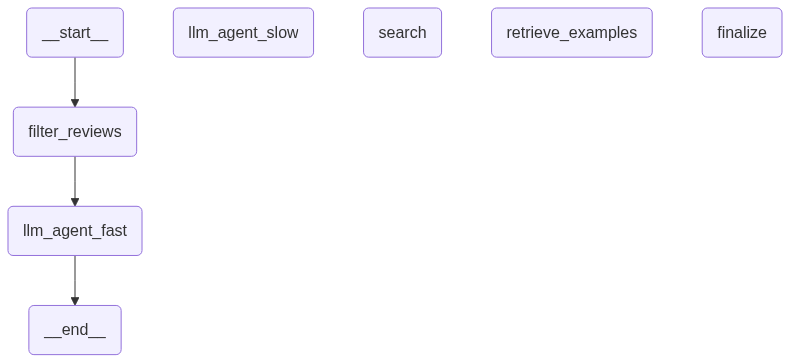

In [57]:
graph = build_graph()

display(Image(graph.get_graph().draw_mermaid_png()))

## Смотрим работу на train_data

In [30]:
sample_data = train_data.sample(n=10, random_state=21)

In [31]:
import time

results = []

# строим граф
graph = build_graph()

for i, (_, row) in enumerate(sample_data.iterrows()):  # <---- !!!

    print(f'\n-----------------------№{i}------------------------\n')

    input_dict = {
        **row.to_dict(),
        "base_fewshot_examples": [], # base_fewshot_examples,
        "retrieved_fewshot_examples": [],
        "search_snippet": "",
        "search_result_url": "",
    }

    result = graph.invoke(input_dict)
    results.append(result)

    time.sleep(1.1)

df_preds = pd.DataFrame(results)


-----------------------№0------------------------


Запрос: [ремонт rjvgm.nthjd егорьевск]
Организация: [Седьмое Небо; Seventh Sky; Натяжные потолки, Московская область, Егорьевск, улица Александра Невского, 2, Плюсы: установка потолков; квалифицированные услуги по монтажу; профессионализм менеджера; профессионализм монтажников; чистота работы  
Минусы: нет]
Релевантность
--- llm_label: IRRELEVANT
--- assessor_label: IRRELEVANT

-----------------------№1------------------------


Запрос: [рыбные рестораны в казани]
Организация: [Кафе-бар Носорог; Cafe-bar Nosorog; Nosorog; Носорог; Кафе Носорог; Cafe Nosorog; Cafe bar Nosorog; Rhino, Республика Татарстан (Татарстан), Казань, Ново-Савиновский район, Меридианная улица, 2, Кафе-бар «Носорог» предлагает разнообразные блюда: от лёгких закусок и салатов до сытных супов и стейков, а также десерты и завтраки. В меню есть мясные, рыбные и овощные блюда, брускетты, паста, ризотто и соусы. | бизнес-ланч | салат «Цезарь» | стейк «Рибай» | суп «То

## Валидация на eval_data

In [32]:
# отключаем логгирование на валидации — чтобы не "подглядывать" в процесс и не нарушать чистоту оценки

# Отключим print
import builtins
original_print = print
builtins.print = lambda *args, **kwargs: None

# пересобираем граф
graph = build_graph()

results = []
for (_, row) in tqdm(eval_data.iterrows(), total=len(eval_data)):

    input_dict = {
        **row.to_dict(),
        "base_fewshot_examples": [],
        "retrieved_fewshot_examples": [],
        "search_snippet": "",
        "search_result_url": "",
    }

    result = graph.invoke(input_dict)
    results.append(result)

    time.sleep(1.1)

df_preds = pd.DataFrame(results)


# Включим print обратно
builtins.print = original_print

100%|██████████| 500/500 [52:46<00:00,  6.33s/it]


In [33]:
y_true = df_preds['assessor_label']
y_pred = df_preds['llm_label']

print('Final Accuracy:')
accuracy_score(y_true, y_pred)

Final Accuracy:


0.77

In [ ]:
# Меняю метки на исходные

df_preds["llm_label"] = df_preds["llm_label"].replace({
    'RELEVANT_PLUS': 1.0,
    'IRRELEVANT': 0.0
}).astype(float)

df_preds["assessor_label"] = df_preds["assessor_label"].replace({
    'RELEVANT_PLUS': 1.0,
    'IRRELEVANT': 0.0
}).astype(float)


# llm_label - предсказанная метка
df_preds.to_csv("/content/drive/MyDrive/llm-agent_results500.csv", index=False)
